# Imports

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Astonishingly there seems to be no clean way to set up the Python path automatically for a script that does not
# reside in the root folder. This will need to be added to all notebooks unless a better solution comes along.
import os, sys
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import scipy

sns.set_theme()

# Load Data

In [3]:
# For each model we want to compare, list its name and the path to its eval results.
MODELS = [
    ("ANML", "/gpfs2/scratch/ntraft/Development/higherANML/experiments/omni-init-fix/eval"),
    ("SANML", "/gpfs2/scratch/ntraft/Development/higherANML/experiments/omni-sanml/eval"),
]
MODELS = [(n, Path(p).resolve()) for n, p in MODELS]

For brevity, we want each model to have a "short name" that can be used in plots and legends. This will replace the original `model` column, which is a filename.

In [24]:
%%time

from tqdm import tqdm

# Filter out learning rates higher than this.
MAX_LR = 0.01
all_frames = []
for name, map_data_folder in MODELS:
    print(f"Loading from: {map_data_folder}")
    curr_frames = [pd.read_pickle(f) for f in map_data_folder.glob("*.pkl")]
    print(f"    Loaded {len(curr_frames)} dataframes for {name}.")
    if MAX_LR:
        curr_frames = list(filter(lambda df: df.index.get_level_values("lr")[0] <= MAX_LR, curr_frames))
        print(f"    Filtered down to {len(curr_frames)} dataframes.")
    # Replace model path with model shortname.
    # TODO: Need to find a more efficient way to do this.
    for df in tqdm(curr_frames):
        # Here's the original way to do it, and it's way too slow.
        #orig = df.index.get_level_values("model")[0]  # Get original name.
        #df.rename(index={orig: name}, level="model", inplace=True)  # Replace with short name.
        newdex = df.index.to_frame(index=False)
        newdex["model"] = [name] * len(newdex["model"])  # Replace entire model column w/ short name.
        newdex = pd.MultiIndex.from_frame(newdex, names=df.index.names)
        df.set_index(newdex, inplace=True)
    all_frames.extend(curr_frames)
all_data = pd.concat(all_frames)
print(f"Loaded total {len(all_frames)} dataframes for total size = {all_data.shape}")

Loading from: /gpfs2/scratch/ntraft/Development/higherANML/experiments/omni-init-fix/eval
    Loaded 20 dataframes for ANML.
    Filtered down to 17 dataframes.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:09<00:00,  4.07s/it]


Loading from: /gpfs2/scratch/ntraft/Development/higherANML/experiments/omni-sanml/eval
    Loaded 20 dataframes for SANML.
    Filtered down to 17 dataframes.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:10<00:00,  4.16s/it]


Loaded total 34 dataframes for total size = (122400000, 2)
CPU times: user 3min 20s, sys: 25.8 s, total: 3min 46s
Wall time: 6min 9s


In [25]:
# Clear up what memory we can, in case we are loading some large frames...
# In my experiment with 144M rows, this took memory from 7.2 GB --> 6.2 GB; not that much, unfortunately.
import gc
del df
del curr_frames
del newdex
del all_frames
gc.collect()

0

# Utility Functions

In [26]:
def ensure_unique(df, index_columns):
    """
    Ensures that the given columns only contain one value; otherwise raises an exception.

    This is a safety check to ensure we don't erroneously aggregate across runs that aren't comparable. For example,
    if our dataframe could have results from more than one model, we don't usually want to aggregate over all models,
    so we would pass in the "model" column here.
    """
    if isinstance(index_columns, str):
        index_columns = [index_columns]
    for col in index_columns:
        unique = df.index.get_level_values(col).unique()
        if len(unique) > 1:
            raise RuntimeError(f"Refusing to aggregate across runs with different '{col}': {unique.to_numpy()}.")

# Performance Curves

For the subsequent plots, we only want to evaluate on classes seen so far, so let's insert NaN values in places where the class had not yet been trained on.

In [27]:
# Change this line to not copy in order to save memory; but this will lose data.
classes_seen_perf = all_data#.copy()

# Nix all rows where classes_trained <= class_id.
unseen_rows = (classes_seen_perf.index.get_level_values("classes_trained") <= 
               classes_seen_perf.index.get_level_values("class_id"))
classes_seen_perf[unseen_rows] = np.nan

For each training configuration, get a series of average performance per classes trained. First, we want to average over all classes to get overall performance numbers.

In [28]:
%%time

# Average over all classes to get overall performance numbers, by grouping by columns other than class.
groupby_labels = ["model", "dataset", "num_train_examples", "num_test_examples", "lr", "classes_trained", "trial"]
over_all_classes = classes_seen_perf.groupby(groupby_labels).mean()

CPU times: user 49 s, sys: 41.8 s, total: 1min 30s
Wall time: 7min 24s


In [29]:
# Optional deletion of original data to save even more memory.
del classes_seen_perf
del all_data
gc.collect()

0

Now, plot a graph with the best learning rate per data point.

In [30]:
# First group the potential data for each data point separately. This consists of groups over all trials and all
# learning rates.
train_cfg_cols = ["model", "dataset", "num_train_examples", "num_test_examples", "classes_trained"]
train_cfg_groups = over_all_classes.groupby(train_cfg_cols)

def select_best_lr(train_group):
    """
    Reduces a dataframe with many learning rates to one with one learning rate, retaining all trials for the selected
    learning rate. Learning rate is selected by highest mean test accuracy.
    """
    lr_perf = train_group.groupby("lr").mean()
    # Tells us which LR is the best.
    best_lr = lr_perf.iloc[lr_perf.loc[:, "test_acc"].argmax()].name
    # Grabs all trials corresponding to the best LR.
    rows = train_group.index.get_level_values("lr") == best_lr
    # We must remove all the columns that are already specified by the group, because otherwise .apply() is not smart
    # enough to remove them and they will be duplicated.
    return train_group.loc[rows].reset_index(level=train_cfg_cols, drop=True)

# For each point on the x-axis, select the learning rate with the best average performance over trials.
# Need to use .apply() here because our function needs all columns at once.
best_trials_per_point = train_cfg_groups.apply(select_best_lr)

Final accuracy on 600 classes:
      ANML | 69.2% (std: 0.7%)
     SANML | 69.0% (std: 1.0%)


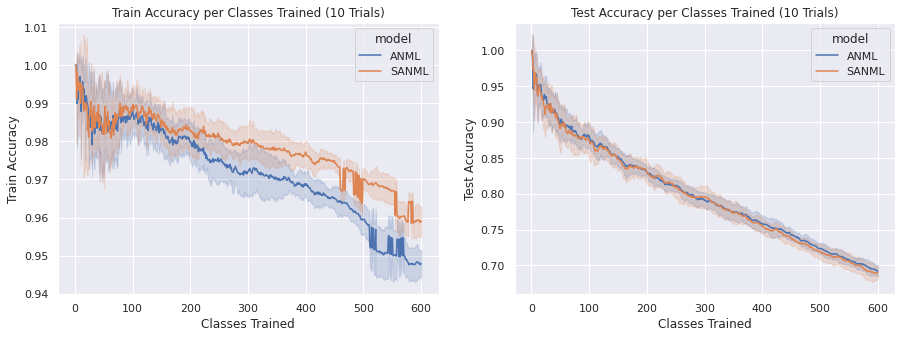

In [31]:
# Plot the results from the previous cell.
def plot_traj_per_lr(df, metric_name, colname, ax=None):
    # We want to make sure we are not accidentally aggregating across runs with different configs.
    ensure_unique(df, ["dataset", "num_test_examples"])
    # Only add more levels of nesting if needed.
    hue = None
    if df.index.get_level_values("model").nunique() > 1:
        hue = "model"
    style = None
    if df.index.get_level_values("num_train_examples").nunique() > 1:
        style = "num_train_examples"
    ax = sns.lineplot(
        data=df,
        x="classes_trained",
        y=colname,
        hue=hue,
        style=style,
        ci="sd",  # Remove this to plot 95% CI instead. It will take a long time.
        ax=ax,
    )
    ntrials = df.index.get_level_values("trial").nunique()
    ax.set_title(f"{metric_name} per Classes Trained ({ntrials} Trials)")
    ax.set_xlabel("Classes Trained")
    ax.set_ylabel(metric_name)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_traj_per_lr(best_trials_per_point, "Train Accuracy", "train_acc", ax=ax1)
plot_traj_per_lr(best_trials_per_point, "Test Accuracy", "test_acc", ax=ax2)

# Print final accuracy per model
models = best_trials_per_point.index.get_level_values("model")
classes_trained = best_trials_per_point.index.get_level_values("classes_trained")
num_classes = classes_trained.max()
print(f"Final accuracy on {num_classes} classes:")
for m in models.unique():
    rows = (classes_trained == num_classes) & (models == m)
    final_acc = best_trials_per_point.loc[rows, "test_acc"]
    print(f"{m: >10} | {final_acc.mean():.1%} (std: {final_acc.std():.1%})")

# Sensitivity to Learning Rate

In [32]:
# Combine train/test columns into a single column, for the convenience of using `sns.relplot()`.
overall_accuracy = over_all_classes.rename(columns={"train_acc": "train", "test_acc": "test"})
overall_accuracy = overall_accuracy.melt(var_name="split", value_name="accuracy", ignore_index=False)

CPU times: user 2.2 s, sys: 59.4 ms, total: 2.26 s
Wall time: 3.35 s


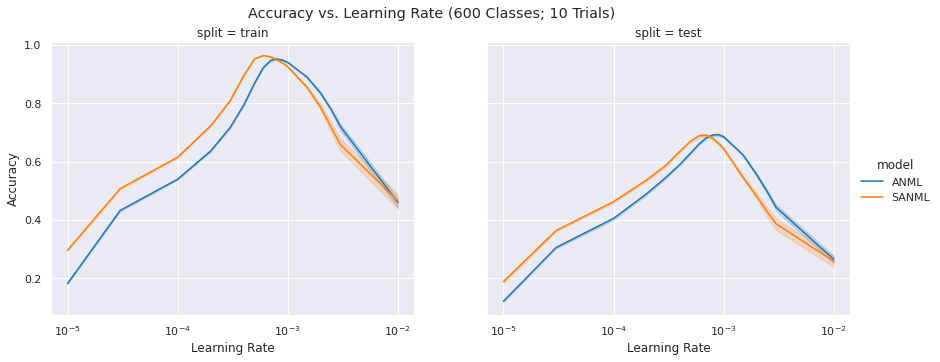

In [52]:
%%time

import warnings
from numbers import Number

# We want to plot the result of learning this number of classes across different choices of learning rate.
def plot_perf_vs_learning_rate(df, num_classes_learned, lr_range=None):

    # Filter down to just the slice that has learned this many classes.
    if isinstance(num_classes_learned, Number):
        # Convert to list of numbers first.
        num_classes_learned = [num_classes_learned]
    classes_trained = df.index.get_level_values("classes_trained")
    df = df.loc[classes_trained.map(lambda x: x in num_classes_learned), :]
    
    # Filter to only the desired learning rates.
    if lr_range:
        assert len(lr_range) == 2
        lrs = df.index.get_level_values("lr")
        rows = (lrs >= lr_range[0]) & (lrs <= lr_range[1])
        df = df.loc[rows, :]        
    
    # We want to make sure we are not accidentally aggregating across runs with different configs.
    ensure_unique(df, ["dataset", "num_test_examples"])
    # Only add more levels of nesting if needed.
    hue = None
    if df.index.get_level_values("model").nunique() > 1:
        hue = "model"
    style = None
    nte = df.index.get_level_values("num_train_examples")
    ct = df.index.get_level_values("classes_trained")
    if nte.nunique() > 1 and ct.nunique() > 1:
        # We can't have both of these at once.
        raise RuntimeError("Cannot show multiple values of both 'num_train_examples' and 'classes_trained'.")
    elif ct.nunique() > 1:
        style = "classes_trained"
    elif nte.nunique() > 1:
        style = "num_train_examples"

    # Temporarily suppress this annoying and unnecessary warning coming from Seaborn.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*not compatible with tight_layout.*")
        fg = sns.relplot(
            data=df,
            x="lr",
            y="accuracy",
            col="split",
            hue=hue,
            style=style,
            palette="tab10",
            kind="line",
            #ci="sd",  # Remove this to plot 95% CI instead. It will take a long time.
            aspect=1.3,
            facet_kws=dict(gridspec_kws=dict(top=0.88))
        )
    # Adjust labels.
    ntrials = df.index.get_level_values("trial").nunique()
    fg.set(xscale="log")
    cls_text = ""
    if len(num_classes_learned) == 1:
        cls_text = f"{num_classes_learned[0]} Classes; "
    fg.figure.suptitle(f"Accuracy vs. Learning Rate ({cls_text}{ntrials} Trials)")
    fg.set_axis_labels("Learning Rate", "Accuracy")


# Determine which point(s) on the learning trajectories to plot.
num_classes = [600]
# Now do the plotting.
plot_perf_vs_learning_rate(overall_accuracy, num_classes)#, lr_range=(float("-inf"), 0.03))

# Scratch Space

In [19]:
# Summarizing the final performance across all runs in a single dataframe.
one_file = next(Path(".").glob("*.pkl"))
print(f"Loading runs from {one_file}")
df = pd.read_pickle(one_file)
print(f"Dataframe shape: {df.shape}")

# Average over all classes to get overall performance numbers, by grouping by columns other than class.
non_class_labels = list(filter(lambda x: x != "class_id", df.index.names))
avg_over_classes = df.groupby(non_class_labels).mean()
# Get just the final test accuracy of each run (when we've trained on all classes).
classes_trained = avg_over_classes.index.get_level_values("classes_trained")
num_classes = classes_trained.max()
print(f"Final accuracy on {num_classes} classes:")
final_acc = avg_over_classes.loc[classes_trained == num_classes, "test_acc"]
print(f"{final_acc.mean():.1%} (std: {final_acc.std():.1%})")

Loading runs from gpfs2-scratch-ntraft-Development-higherANML-experiments-omni-sanml-trained_anmls-sanml-1-28-28-29999.net-omni-600-15-5-0.001.pkl
Dataframe shape: (3600000, 2)
Final accuracy on 600 classes:
64.5% (std: 0.8%)
